In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats as st
import itertools as it
from tqdm import tqdm_notebook as tqdm
from matplotlib.animation import FuncAnimation
import random
import modelutils
plt.ion()

Defining helper functions here...

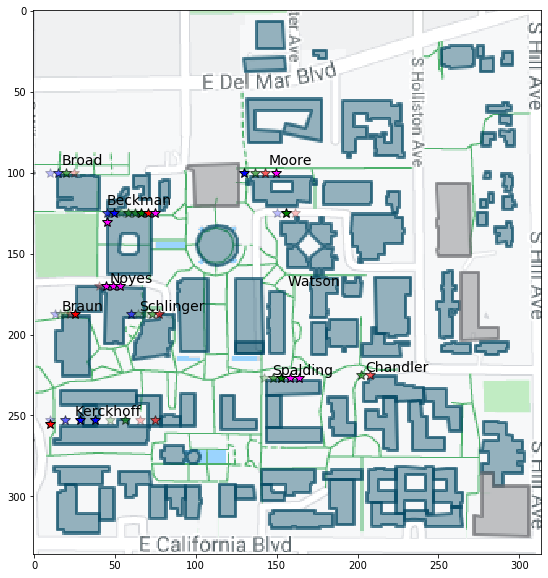

In [2]:
npeople=50
campus_map = plt.imread('campus_map.png')

fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(campus_map)

locations=['Broad','Moore','Watson','Beckman','Noyes','Braun','Schlinger','Kerckhoff','Spalding','Chandler']


agent_locations = np.random.choice(locations,size=npeople)
disease_states = np.random.choice(np.arange(10),size=npeople)
background_map = plt.imread('campus_map.png')

def draw_campus(agent_locations,disease_states,ax,background_map = plt.imread('campus_map.png')):
    """
    agent locations is a list containing the location of each agent in the simulation
    disease states is a list of booleans describing whether or not an individual is infected (0=healthy,1=infected)
    ax is the matplotlib axes object you want to draw on
    
    returns nothing, operates in-place
    """

    #group together states so they're not randomly shuffled
    agent_locations = [x for _,x in sorted(zip(disease_states,agent_locations))] 
    disease_states = sorted(disease_states)

    locations=['Broad','Moore','Watson','Beckman','Noyes','Braun','Schlinger','Kerckhoff','Spalding','Chandler']
    alphaarray = np.linspace(0.25,1,num=3)
    colors=['blue','green','red']

    ax.imshow(background_map)


    #add labels
    ax.text(17,95,'Broad',size=14)
    ax.text(145,95,'Moore',size=14)
    ax.text(157,170,'Watson',size=14)
    ax.text(45,120,'Beckman',size=14)
    ax.text(47,168,'Noyes',size=14)
    ax.text(17,185,'Braun',size=14)
    ax.text(65,185,'Schlinger',size=14)
    ax.text(25,250,'Kerckhoff',size=14)
    ax.text(147,225,'Spalding',size=14)
    ax.text(205,223,'Chandler',size=14)

    #each value is a 2 list describing the ranges on x and y for that location
    coor_ranges = {
        'Broad': [[10,45],[100,125]],
        'Moore': [[130,175],[100,125]],
        'Watson': [[150,190],[125,160]],
        'Beckman': [[45,75],[125,165]],
        'Noyes': [[40,70],[170,205]],
        'Braun':[[13,35],[187,227]],
        'Schlinger':[[60,90],[187,215]],
        'Kerckhoff':[[10,75],[253,270]],
        'Spalding':[[142,180],[227,240]],
        'Chandler':[[202,242],[225,242]]   
    }

    people_counter = np.zeros(len(coor_ranges.keys())).astype(np.int)

    gridlen = np.ceil(np.sqrt(npeople)).astype(np.int) #create enough gridpoints such that everyone has a space if they mob a single location (chandler)

    #iterate over people and draw each on the axis
    for person_idx in range(len(agent_locations)):

        color_idx = int(disease_states[person_idx]//3)
        alpha_idx = int(disease_states[person_idx] % 3)
        if color_idx<=2:
            color=colors[color_idx]
            alpha=alphaarray[alpha_idx]
        elif disease_states[person_idx]==9:
            color='magenta'
            alpha=1
        elif disease_states[person_idx]==10:
            color='black'
            alpha=1

        people_counter[locations.index(agent_locations[person_idx])] += 1

        #draw a grid over the current location and place agent at specified spot
        current_ranges = coor_ranges[agent_locations[person_idx]]
        xx,yy = np.meshgrid(np.linspace(current_ranges[0][0],current_ranges[0][1],num=gridlen),np.linspace(current_ranges[1][0],current_ranges[1][1],num=gridlen))

        #we need to convert the raw counts into row,col indices to get the coordinates of interest
        pal = people_counter[locations.index(agent_locations[person_idx])]-1 #again, -1 is for indexing. pal stands for people at location

        ax.plot(xx[pal//gridlen,pal%gridlen],yy[pal//gridlen,pal%gridlen],color=color,alpha=alpha,marker='*',markersize=10,markeredgecolor='black')


draw_campus(agent_locations,disease_states,ax)

### Main Simulation

In [3]:
ndays=5
agent_locations,agent_states = modelutils.run_simulation(ndays,npeople,locations)
agent_locations_nolunch,agent_states_nolunch = modelutils.run_simulation(ndays,npeople,locations,lunchtimes = [[99999*np.ones(npeople)],[99999*np.ones(npeople)]])  #the simulation will never hit this counter value

Day:  4 / 5


Day:  4 / 5


Visualization and animation code below.

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


GIF Finished!  480


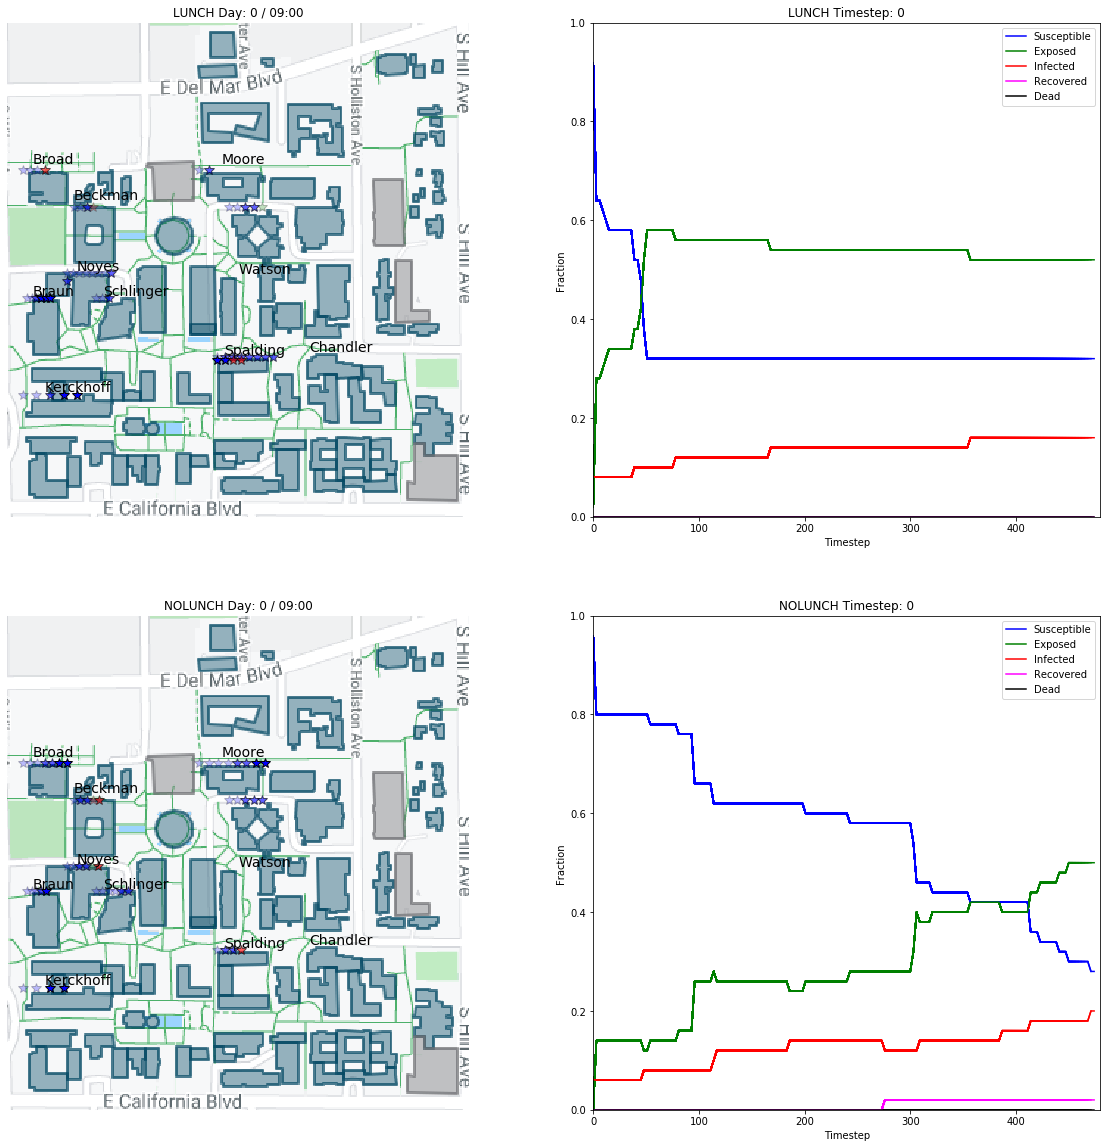

In [4]:
def num2titlestr(n):
    day = n//96
    day_rem = n % 96
    hours = day_rem // 12
    
    fmt_hours = 9 + hours
    if fmt_hours>12:
        fmt_hours+=-12
    fmt_hours= str(fmt_hours)
    if len(fmt_hours)!=2:
        fmt_hours = '0'+fmt_hours
    
    hour_rem = day_rem % 12
    minutes = hour_rem * 5
    fmt_minutes = str(minutes)
    if len(fmt_minutes) != 2:
        fmt_minutes = '0'+fmt_minutes
    return 'Day: '+str(day)+' / '+ fmt_hours+':'+fmt_minutes


fig,ax = plt.subplots(nrows=2,ncols=2,figsize=[20,20])
skip=3

state_counts = np.zeros(shape=[agent_locations.shape[0],5]) #s,e,i,r,d in that order
state_counts_nolunch = np.zeros(shape=[agent_locations.shape[0],5])

ax[0,1].set_xlabel('Timestep')
ax[0,1].set_ylabel('Fraction')
ax[1,1].set_xlabel('Timestep')
ax[1,1].set_ylabel('Fraction')


plot_colors=['blue','green','red','magenta','black']

def update(i,skip=skip):
    print('Step: ',i,' / ',agent_locations.shape[0],end='\r')
    
        
    plot_indices = np.arange(0,i,step=skip)
        
    ax[0,0].clear()
    ax[0,0].set_title('LUNCH '+num2titlestr(i))
    ax[1,0].clear()
    ax[1,0].set_title('NOLUNCH '+num2titlestr(i)) 
    
    
    disease_states = np.squeeze(agent_states[i,:,:])  #we need to "compress this one hot matrix (one hot along columns)"
    disease_states = np.array([np.where(disease_states[:,x]==1)[0] for x in range(disease_states.shape[1])])
    
    disease_states_nolunch = np.squeeze(agent_states_nolunch[i,:,:])  #we need to "compress this one hot matrix (one hot along columns)"
    disease_states_nolunch = np.array([np.where(disease_states_nolunch[:,x]==1)[0] for x in range(disease_states_nolunch.shape[1])])
    
    for idx in range(disease_states.size):
        current_state = disease_states[idx]

        if current_state<=2:
            state_counts[i,0]+=1

        elif current_state>2 and current_state <=5:
            state_counts[i,1]+=1

        elif current_state>5 and current_state<=8:
            state_counts[i,2]+=1

        elif current_state==9:
            state_counts[i,3]+=1

        elif current_state==10:
            state_counts[i,4]+=1
            
            
    
    
    for idx in range(disease_states.size):
        current_state = disease_states_nolunch[idx]

        if current_state<=2:
            state_counts_nolunch[i,0]+=1

        elif current_state>2 and current_state <=5:
            state_counts_nolunch[i,1]+=1

        elif current_state>5 and current_state<=8:
            state_counts_nolunch[i,2]+=1

        elif current_state==9:
            state_counts_nolunch[i,3]+=1

        elif current_state==10:
            state_counts_nolunch[i,4]+=1
            
            
    state_counts[i,:] /=     npeople
    state_counts_nolunch[i,:] /=     npeople

    draw_campus(agent_locations[i,:],disease_states,ax[0,0])
    draw_campus(agent_locations_nolunch[i,:],disease_states,ax[1,0])
    
    ax[0,0].axis('off')
    ax[1,0].axis('off')
    
    for plot_idx in range(5):
        ax[0,1].plot(plot_indices,state_counts[plot_indices,plot_idx],color=plot_colors[plot_idx])
        ax[1,1].plot(plot_indices,state_counts_nolunch[plot_indices,plot_idx],color=plot_colors[plot_idx])
        
    ax[0,1].set_title('LUNCH Timestep: '+str(i))
    ax[0,1].set_ylim([0,1])
    ax[0,1].set_xlim([0,480])
    ax[0,1].legend(['Susceptible','Exposed','Infected','Recovered','Dead'])
    
    ax[1,1].set_title('NOLUNCH Timestep: '+str(i))
    ax[1,1].set_ylim([0,1])
    ax[1,1].set_xlim([0,480])
    ax[1,1].legend(['Susceptible','Exposed','Infected','Recovered','Dead'])
    


anim = FuncAnimation(fig, update, frames=np.arange(0, agent_locations.shape[0],skip), interval=200,repeat_delay=1000)

anim.save('200630.gif', dpi=80, writer='imagemagick')
print('GIF Finished!')

In [5]:
ntrials = 100

prev_locations=agent_locations[-96:,:]
init_state = agent_states[-96,...]
loc_weights = st.uniform.rvs(size=10)

returnarray_200 = modelutils.forecast(200,prev_locations,locations,init_state,loc_weights)
returnarray_100 = modelutils.forecast(ntrials,prev_locations,locations,init_state,loc_weights)
returnarray_50 = modelutils.forecast(50,prev_locations,locations,init_state,loc_weights)
returnarray_25 = modelutils.forecast(25,prev_locations,locations,init_state,loc_weights)
returnarray_10 = modelutils.forecast(10,prev_locations,locations,init_state,loc_weights)

MC Trial:  199 / 200


MC Trial:  99 / 100


MC Trial:  49 / 50


MC Trial:  24 / 25


MC Trial:  9 / 10


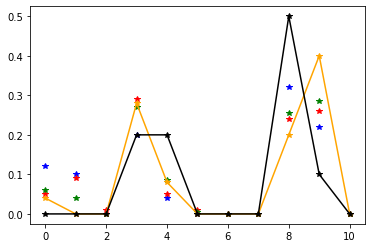

In [6]:
fig,ax = plt.subplots()
ax.plot(returnarray_50[:,2],'*b')
ax.plot(returnarray_100[:,2],'*r')
ax.plot(returnarray_200[:,2],'*g')
ax.plot(returnarray_25[:,2],color='orange',marker='*')
ax.plot(returnarray_10[:,2],color='black',marker='*')